In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
from competitions.dsb2017 import dsbconfig as comp;
import dicom
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from nbpapaya import Brain, clear_brain, Brain, Surface, Overlay
import SimpleITK as sitk
import csv
import xml
from bs4 import BeautifulSoup

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Kaggle Data

In [ ]:
"""
http://pydicom.readthedocs.io/en/stable/getting_started.html
https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial/notebook
https://www.kaggle.com/c/data-science-bowl-2017
https://github.com/lfz/DSB2017
http://nbviewer.jupyter.org/github/bckenstler/dsb17-walkthrough/blob/master/Part%201.%20DSB17%20Preprocessing.ipynb
https://www.youtube.com/watch?v=BmkdAqd5ReY (Intro to CT scans)
http://www.dspguide.com/ch25/5.htm
""";

In [ ]:
patients = sorted(os.listdir(cfg.SAMPLE_IMAGE_PATH))

In [ ]:
# Load the scans in given 'patient' dir
# One directory is one scan of multiple slices
# We calculate the pixel size in the Z direction (slice thickness), since not provided
# Returns list of slices (dicom format)
def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
    
    return slices

In [ ]:
patient_idx = random.randint(0,len(patients))
patient_path = os.path.join(cfg.SAMPLE_IMAGE_PATH, patients[patient_idx])
patient_fnames, pat_fpaths = utils.files.get_paths_to_files(patient_path)
scan1 = load_scan(patient_path)

In [ ]:
# Metadata
scan1

In [ ]:
# Convert to Hounsfield Units (HU)
# Unit of measurement in CT scans is the Hounsfield Unit (HU), which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this.
# Radiodensity - measurement of how absorbent a material is to X-rays. This naturally differs for different materials, so by measuring this we have a way of visualizing the interior tissues and so forth.
# Convert to HU by multiplying with the rescale slope and adding the intercept (which are conveniently stored in the metadata of the scans!).

# Returns np array of slices in HUs
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [ ]:
first_patient_scan = load_scan(patient_path)
first_patient_pixels = get_pixels_hu(first_patient_scan)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [ ]:
"""
A scan may have a pixel spacing of [2.5, 0.5, 0.5], which means that the distance between slices is 2.5 millimeters. For a different scan this may be [1.5, 0.725, 0.725], this can be problematic for automatic analysis (e.g. using ConvNets)!

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm1mm1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance.
"""

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [ ]:
first_patient_resampled_img, resample_spacing = resample(first_patient_pixels, first_patient_scan)
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", first_patient_resampled_img.shape)

In [ ]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [ ]:
plot_3d(first_patient_resampled_img, 400)

In [ ]:
## Lung Segmentation

"""
1) Threshold the image (-320 HU is a good threshold, but it doesn't matter much for this approach)
2) Do connected components, determine label of air around person, fill this with 1s in the binary image
3) Optionally: For every axial slice in the scan, determine the largest solid connected component (the body+air around the person), and set others to 0. This fills the structures in the lungs in the mask.
4) Keep only the largest air pocket (the human body has other pockets of air here and there).
""";

In [ ]:
"""
Normalization --

Our values currently range from -1024 to around 2000. Anything above 400 is not interesting to us, as these are simply bones with different radiodensity. A commonly used set of thresholds in the LUNA16 competition to normalize between are -1000 and 400. Here's some code you can use:

Zero Centering --

Zero center your data so that your mean value is 0. Subtract the mean pixel value from all pixels. To determine this mean you simply average all images in the whole dataset. If that sounds like a lot of work, we found this to be around 0.25 in the LUNA16 competition.

* DO NOT zero center with the mean per `image`
"""

MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image


PIXEL_MEAN = 0.25

def zero_center(image):
    image = image - PIXEL_MEAN
    return image

In [ ]:
"""
Run Pre-processing Tonight!!

To save storage space, don't do normalization and zero centering beforehand, but do this online (during training, just after loading)
"""

### Luna Data

In [20]:
"""
https://github.com/dhammack/DSB2017/blob/master/training_code/DLung/data_generator_fn.py
https://github.com/juliandewit/kaggle_ndsb2017/blob/master/step1_preprocess_luna16.py
https://www.kaggle.com/arnavkj95/candidate-generation-and-luna16-preprocessing/notebook
https://github.com/booz-allen-hamilton/DSB3Tutorial
https://gist.github.com/ajsander/ea33b90cc6fcff2696cd3b350ed7f86c
https://github.com/juliandewit/kaggle_ndsb2017/blob/master/step1b_preprocess_make_train_cubes.py
https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI#96d911248b584775bb65cdd4a4883550
https://pyscience.wordpress.com/2014/11/02/multi-modal-image-segmentation-with-python-simpleitk/
https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks
https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/03_Image_Details.ipynb
https://github.com/nipy/nibabel
https://pyscience.wordpress.com/2014/11/02/multi-modal-image-segmentation-with-python-simpleitk/
""";

In [21]:
PROJECT_PATH = os.path.join('/bigguy/data/luna')
DATA_PATH = os.path.join('/bigguy/data/luna/data')
META_PATH = os.path.join(PROJECT_PATH, 'csv')
EXTRACTED_IMG_PATH = os.path.join(PROJECT_PATH, 'extracted_imgs')
EXTRACTED_LABEL_PATH = os.path.join(PROJECT_PATH, 'extracted_labels')
ANNOTATIONS_PATH = os.path.join(META_PATH, 'annotations.csv')
LIDC_ANNO_PATH = os.path.join(META_PATH, 'lidc_annotations')
MEAN_PIXEL_VALUE_NODULE = 41
SEGMENTER_IMG_SIZE = 320
TARGET_VOXEL_MM = 1.00

subset_path = os.path.join(DATA_PATH, 'subset0')
fpaths = glob(subset_path+"/*.mhd")
def get_filename(case):
    global fpaths
    for f in fpaths:
        if case in f:
            return(f)

In [22]:
len(fpaths), fpaths[0]

(89,
 '/bigguy/data/luna/data/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd')

In [13]:
annotations_df = pd.read_csv(ANNOTATIONS_PATH)
annotations_df["file"] = annotations_df["seriesuid"].apply(get_filename)
annotations_df = annotations_df.dropna()

In [14]:
len(annotations_df)

112

In [15]:
fcount = 0
for img_file in fpaths:
    #print("Getting mask for image file %s" % img_file.replace(subset_path,""))
    mini_df = annotations_df[annotations_df["file"]==img_file] #get all nodules associate with file
    if len(mini_df)>0:       # some files may not have a nodule--skipping those 
        biggest_node = np.argsort(mini_df["diameter_mm"].values)[-1]   # just using the biggest node
        node_x = mini_df["coordX"].values[biggest_node]
        node_y = mini_df["coordY"].values[biggest_node]
        node_z = mini_df["coordZ"].values[biggest_node]
        diam = mini_df["diameter_mm"].values[biggest_node]

### Visualize Images

In [16]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)
        
def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    size = img.GetSize()
    img_xslices = [img[s,:,:] for s in xslices]
    img_yslices = [img[:,s,:] for s in yslices]
    img_zslices = [img[:,:,s] for s in zslices]
    
    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))
    
    img_null = sitk.Image([0,0], img.GetPixelID(), img.GetNumberOfComponentsPerPixel())
    
    img_slices = []
    d = 0
    
    if len(img_xslices):
        img_slices += img_xslices + [img_null]*(maxlen-len(img_xslices))
        d += 1
        
    if len(img_yslices):
        img_slices += img_yslices + [img_null]*(maxlen-len(img_yslices))
        d += 1
     
    if len(img_zslices):
        img_slices += img_zslices + [img_null]*(maxlen-len(img_zslices))
        d +=1
    
    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen,d])
        #TO DO check in code to get Tile Filter working with vector images
        else:
            img_comps = []
            for i in range(0,img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen,d]))
            img = sitk.Compose(img_comps)
            
    
    myshow(img, title, margin, dpi)

In [17]:
img_file = list(annotations_df["file"])[0]
itk_img = sitk.ReadImage(img_file)
img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
nda = sitk.GetArrayViewFromImage(itk_img)
center = np.array([node_x,node_y,node_z])   # nodule center
origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
v_center =np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)

In [26]:
%pwd

'/home/bfortuner/workplace/dsb2017'

In [28]:
#sitk.WriteImage(itk_img, "tst.nii")
Brain("dsb2017/tst.nii")

doing checks /home/bfortuner/.jupyter/custom/


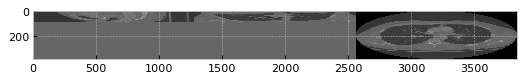

In [43]:
size = itk_img.GetSize()
slices =[itk_img[size[0]//2,:,:], itk_img[:,size[1]//2,:], itk_img[:,:,size[2]//2]]
myshow(sitk.Tile(slices, [3,1]), dpi=20)

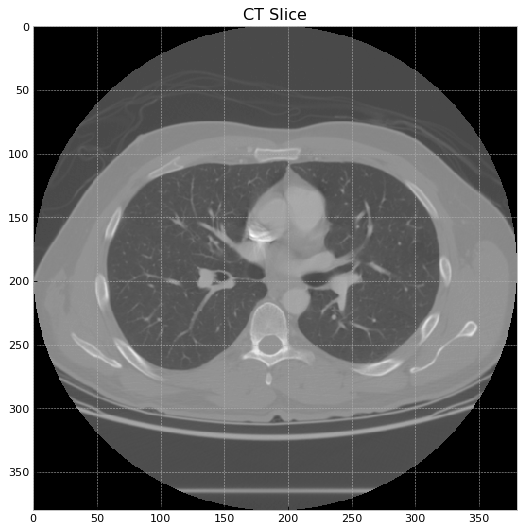

In [33]:
myshow(itk_img, title="CT Slice")

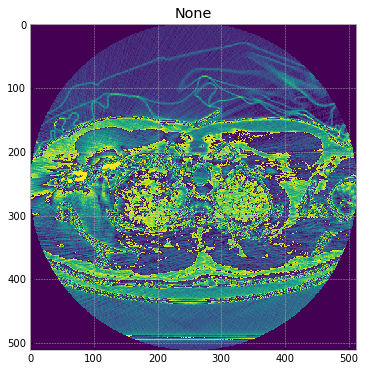

In [27]:
utils.imgs.plot_img_arr(nda[100])

### Extract Annotations

In [49]:
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, 
origin and spacing of the image.
'''
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a numpy array first and then 
    # shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # Read the origin of the ct_scan, will be used to convert 
    # the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan, origin, spacing

def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

def resize_voxel(x, desired_shape):
    factors = np.array(x.shape).astype('float32') / np.array(desired_shape).astype('float32')
    output= ndimage.interpolation.zoom(x,1.0 / factors,order=1)
    assert output.shape == desired_shape, 'resize error'
    return output

In [90]:
img, origin, spacing = load_itk(img_file)

In [93]:
img.shape
img[0]

array([[-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       ..., 
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048]], dtype=int16)

### Get the LIDC Annotations

In [29]:
glob(LIDC_ANNO_PATH+"/*")

['/bigguy/data/luna/csv/lidc_annotations/188',
 '/bigguy/data/luna/csv/lidc_annotations/185',
 '/bigguy/data/luna/csv/lidc_annotations/186',
 '/bigguy/data/luna/csv/lidc_annotations/189',
 '/bigguy/data/luna/csv/lidc_annotations/157',
 '/bigguy/data/luna/csv/lidc_annotations/187']

### Annotation Schemas

In [ ]:
# LIDC
# https://wiki.cancerimagingarchive.net/download/attachments/3539039/LIDC_XML_Documentation_1_Jan_2009.doc?version=1&modificationDate=1319224566057&api=v2
"""
The LIDC used a two phase reading process. In the first phase, multiple readers (N=4 as of Jan 2006), read and annotated each case independently in a blinded fashion.  That is, they all read the same cases, but they the readings were done asynchronously and independently.  After the results of that first, blinded reading were complete, they were compiled and sent back out to the same readers so that they could see both their own markings as well as the markings from the other three readers.  Each reader then, again independently, read each case, this time with the benefit of information as to what other readers saw/marked, and then made a final decisions about the markings for that case.

3 step annotation process:
1) Blind read by 4 radiologists
2) Each radiologist showed the annotations of the others
3) Unblind read by 4 radiologists

IMAGES ONLY INCLUDE THE 2nd Unblinded Read

Interesting!!
Malignancy - Radiologist subjective assessment of likelihood of malignancy of this nodule, ASSUMING  60-year-old male smoker 

3 Types of Annotations:
1) Nodules >= 3mm diameter 
    - Complete outline (segmentation)
    - Include characteristics (e.g. malignancy)
2) Nodules < 3mm diameter 
    - Center of mass labeled (x,y,z)
    - Do not include characteristics
3) Non-Nodules > 3mm  diameter
    - Center of mass labeled (x,y,z)
    - Do not include characteristics

* Non-Nodules < 3mm were NOT marked! (might confuse the model)


Terms
-----
* Scan files = 158.xml, 162.xml..
* SeriesInstanceUid = Patient
* StudyInstanceUID = Scan 

<SeriesInstanceUid>1.3.6.1.4.1.14519.5.2.1.6279.6001.303494235102183795724852353824</SeriesInstanceUid>
<StudyInstanceUID>1.3.6.1.4.1.14519.5.2.1.6279.6001.339170810277323131167631068432</StudyInstanceUID>


* Nodules >= 3mm diameter 

 <unblindedReadNodule>
   <noduleID>6</noduleID>
   <characteristics>
    <subtlety>5</subtlety>
    <internalStructure>1</internalStructure>
    <calcification>4</calcification>
    <sphericity>3</sphericity>
    <margin>5</margin>
    <lobulation>2</lobulation>
    <spiculation>3</spiculation>
    <texture>5</texture>
    <malignancy>4</malignancy>
   </characteristics>
   
   ## ROIS are the same nodule on different slices
   <roi>
    <imageZposition>1616.5</imageZposition>
    <imageSOP_UID>1.3.6.1.4.1.14519.5.2.1.6279.6001.315628943944666928553332863367</imageSOP_UID>
    <inclusion>TRUE</inclusion>
    <edgeMap><xCoord>339</xCoord><yCoord>240</yCoord></edgeMap>
    <edgeMap><xCoord>338</xCoord><yCoord>241</yCoord></edgeMap>
    <edgeMap><xCoord>337</xCoord><yCoord>242</yCoord></edgeMap>
   </roi>
   <roi>
    <imageZposition>1616.5</imageZposition>
    <imageSOP_UID>1.3.6.1.4.1.14519.5.2.1.6279.6001.315628943944666928553332863367</imageSOP_UID>
    <inclusion>TRUE</inclusion>
    <edgeMap><xCoord>339</xCoord><yCoord>240</yCoord></edgeMap>
    <edgeMap><xCoord>338</xCoord><yCoord>241</yCoord></edgeMap>
    <edgeMap><xCoord>337</xCoord><yCoord>242</yCoord></edgeMap>
   </roi>
 </unblindedReadNodule>
 
 
 
* Nodules < 3mm diameter 

  <unblindedReadNodule>
   <noduleID>5</noduleID>
   <roi>
    <imageZposition>1631.5</imageZposition>
    <imageSOP_UID>1.3.6.1.4.1.14519.5.2.1.6279.6001.349696112719071080933041621585</imageSOP_UID>
    <inclusion>TRUE</inclusion>
    <edgeMap><xCoord>197</xCoord><yCoord>321</yCoord></edgeMap>
   </roi>
  </unblindedReadNodule>



* Non-Nodules > 3mm  diameter:

  <nonNodule>
   <nonNoduleID>2058</nonNoduleID>
   <imageZposition>1628.5</imageZposition>
   <imageSOP_UID>1.3.6.1.4.1.14519.5.2.1.6279.6001.216194661683946632889617404306</imageSOP_UID>
   <locus>
    <xCoord>199</xCoord><yCoord>320</yCoord>
   </locus>
  </nonNodule>
"""


In [50]:
def normalize(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image > 1] = 1.
    image[image < 0] = 0.
    return image

def find_mhd_file(patient_id):
    for subject_no in range(10):
        src_dir = os.path.join(
            DATA_PATH, "subset" + str(subject_no)) + "/"
        for src_path in glob(src_dir + "*.mhd"):
            if patient_id in src_path:
                return src_path
    return None

def load_lidc_xml(xml_path, agreement_threshold=0, only_patient=None, save_nodules=False):
    """
    Writes 2 CSV files with nodule and non-nodule annotations
        - nodules >= 3mm
        - non-nodules
    Nodule annotations include: id, z, y, x, diameter, malignancy
    Coords and Diameter are stored as percent of image size
    Diameter is calculated as the max of x and y
        - We reduce irregularly shaped nodules into circles (boxes)
    Optionally include only nodules with radiologist agreement
    Ignores nodules < 3mm
    """
    pos_lines = []
    neg_lines = []
    extended_lines = []
    
    # Each LIDC xml file represents a read of a single 3D CT Scan (multiple slices)
    with open(xml_path, 'r') as xml_file:
        markup = xml_file.read()
    xml = BeautifulSoup(markup, features="xml")
    
    # Catch corrupt files
    if xml.LidcReadMessage is None:
        return None, None, None
    
    patient_id = xml.LidcReadMessage.ResponseHeader.SeriesInstanceUid.text

    # Option to filter for single patient
    if only_patient is not None:
        if only_patient != patient_id:
            return None, None, None

    # Load the CT Scan image by patient_id
    src_path = find_mhd_file(patient_id)
    if src_path is None:
        return None, None, None

    print(patient_id)
    
    # Load the CT Scan with SimpleITK
    # This a 3D volume containing multiple 2D slices
    itk_img = sitk.ReadImage(src_path)
    
    # Convert to Numpy (z, 512, 512)
    img_array = sitk.GetArrayFromImage(itk_img)
    
    # z,y,x (height before width)
    num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
    
    # Needed to calculate offet and normalize
    # Follow-up on this..
    origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
    spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
    
    # 1.00 is a hyperparameter 
    # Rescale so that every voxel represents an volume of 1x1x1 mm
    # Needed to ensure consistency across scans
    rescale = spacing / 1.00 #1x1x1

    # Up to 4 per scan, one per radiologist
    reading_sessions = xml.LidcReadMessage.find_all("readingSession")
    
    # A reading session is all slices in CT Scan read by one radiologist
    for reading_session in reading_sessions:
        
        # Get the list of nodules (since up to 4 reads, many will identify the same nodule)
        nodules = reading_session.find_all("unblindedReadNodule")

        # Includes both >= 3 (characteristics and outline) and <3 (just the centroid)
        for nodule in nodules:
            nodule_id = nodule.noduleID.text # e.g. 1823
            
            # Same nodule appears in multiple slices (3D)
            rois = nodule.find_all("roi")
            
            # To creat the annotations we're going to find the edges
            # of the outline, calculate the center
            # then use the diameter to segment?
            x_min = y_min = z_min = 999999
            x_max = y_max = z_max = -999999
            
            # Skip nodules < 3mm (they only have 1 point (x,y) marked on 1 slicet (the center))
            if len(rois) < 2:
                continue

            # For each slice in nodule >= 3mm
            for roi in rois:
                
                # If Z is < ZMin or >ZMax, update
                z_pos = float(roi.imageZposition.text)
                z_min = min(z_min, z_pos)
                z_max = max(z_max, z_pos)
                
                # Edge maps are single points (x,y) in the outline
                edge_maps = roi.find_all("edgeMap")
                for edge_map in edge_maps:
                    x = int(edge_map.xCoord.text)
                    y = int(edge_map.yCoord.text)
                    x_min = min(x_min, x)
                    y_min = min(y_min, y)
                    x_max = max(x_max, x)
                    y_max = max(y_max, y)
                
                # Catching an edge case 
                # where annotations are crap
                if x_max == x_min:
                    continue
                if y_max == y_min:
                    continue

            # Calculate the diameter + center
            x_diameter = x_max - x_min
            x_center = x_min + x_diameter / 2
            y_diameter = y_max - y_min
            y_center = y_min + y_diameter / 2
            z_diameter = z_max - z_min
            z_center = z_min + z_diameter / 2
            
            # Adjust the center based on origin + spacing
            # Since each scan taken by different machine there
            # is variation..
            z_center -= origin[2]
            z_center /= spacing[2]

            # Calculate the percent (normalized location) of the center
            # with respect to the image size
            # Why?
            # Why are y and x backwards? I thought x would come first....
            x_center_perc = round(x_center / img_array.shape[2], 4)
            y_center_perc = round(y_center / img_array.shape[1], 4)
            z_center_perc = round(z_center / img_array.shape[0], 4)
            
            # Set the diameter to the max of x, y
            # This simplifies the annotation by ignoring ovals 
            # and non-circular nodules..
            diameter = max(x_diameter , y_diameter)
            
            # What percentage is the nodule size of the whole image..
            diameter_perc = round(max(x_diameter / img_array.shape[2], y_diameter / img_array.shape[1]), 4)

            # Skip nodules with important missing fields
            if nodule.characteristics is None:
                print("!!!!Nodule:", nodule_id, " has no charecteristics")
                continue
            if nodule.characteristics.malignancy is None:
                print("!!!!Nodule:", nodule_id, " has no malignacy")
                continue

            # Extract characteristics
            malignacy = nodule.characteristics.malignancy.text
            sphericiy = nodule.characteristics.sphericity.text
            margin = nodule.characteristics.margin.text
            spiculation = nodule.characteristics.spiculation.text
            texture = nodule.characteristics.texture.text
            calcification = nodule.characteristics.calcification.text
            internal_structure = nodule.characteristics.internalStructure.text
            lobulation = nodule.characteristics.lobulation.text
            subtlety = nodule.characteristics.subtlety.text

            # "line" is the primary one we use for model
            # We save the x,y,z,diameter percent relative to image size 
            line = [nodule_id, x_center_perc, y_center_perc, z_center_perc, diameter_perc, malignacy]
            extended_line = [patient_id, nodule_id, x_center_perc, y_center_perc, z_center_perc, diameter_perc,
                             malignacy, sphericiy, margin, spiculation, texture, calcification,
                             internal_structure, lobulation, subtlety ]
            
            # Since this is a nodule >= 3mm, we add this to our list of nodules (TPs)
            pos_lines.append(line)
            
            # Only includes nodules >= 3mm with all attributes
            extended_lines.append(extended_line)

        # Non-Nodules > 3mm  diameter
        # We only have a single z,y,x point for these
        nonNodules = reading_session.find_all("nonNodule")
        for nonNodule in nonNodules:
            z_center = float(nonNodule.imageZposition.text)
            
            # Adjust for offset
            z_center -= origin[2]
            z_center /= spacing[2]
            x_center = int(nonNodule.locus.xCoord.text)
            y_center = int(nonNodule.locus.yCoord.text)
            nodule_id = nonNodule.nonNoduleID.text
            x_center_perc = round(x_center / img_array.shape[2], 4)
            y_center_perc = round(y_center / img_array.shape[1], 4)
            z_center_perc = round(z_center / img_array.shape[0], 4)
            
            # Why 6??????
            diameter_perc = round(max(6 / img_array.shape[2], 6 / img_array.shape[1]), 4)
            
            # Add to list of non-nodules (TNs)
            # line = nodule_id, x_center_perc, y_center_perc, z_center_perc, diameter_perc, malignacy]
            line = [nodule_id, x_center_perc, y_center_perc, z_center_perc, diameter_perc, 0]
            neg_lines.append(line)

    # Option to ignore nodules where
    # multiple radiologists did NOT agree
    if agreement_threshold > 1:
        filtered_lines = []
        
        # Loop through all the nodules
        for pos_line1 in pos_lines:
            id1 = pos_line1[0]
            x1 = pos_line1[1]
            y1 = pos_line1[2]
            z1 = pos_line1[3]
            d1 = pos_line1[4]
            overlaps = 0
            
            # Loop through all nodules again
            for pos_line2 in pos_lines:
                id2 = pos_line2[0]
                
                # Skip the original nodule
                if id1 == id2:
                    continue
                x2 = pos_line2[1]
                y2 = pos_line2[2]
                z2 = pos_line2[3]
                d2 = pos_line1[4]
                
                # Gets the area of overlap???????
                # TODO WHAT does this do..
                dist = math.sqrt(math.pow(x1 - x2, 2) + math.pow(y1 - y2, 2) + math.pow(z1 - z2, 2))

                # If the combined area is less than one or the other
                # Then this is an overlap (>1 radiologists agree)
                if dist < d1 or dist < d2:
                    overlaps += 1
            
            # Add nodule if more than one radiologist agrees
            if overlaps >= agreement_threshold:
                filtered_lines.append(pos_line1)

        # Only overlapping nodule annotations become nodules
        pos_lines = filtered_lines

    # Create DF of all nodules for this CT scan
    df_annos = pd.DataFrame(
        pos_lines, columns=["anno_index", "coord_x", "coord_y", "coord_z", "diameter", "malscore"])
    df_annos.to_csv(os.path.join(EXTRACTED_LABEL_PATH, patient_id + "_annos_pos_lidc.csv"), index=False)

    # Create DF of all non-nodules for this CT scan
    df_neg_annos = pd.DataFrame(
        neg_lines, columns=["anno_index", "coord_x", "coord_y", "coord_z", "diameter", "malscore"])
    df_neg_annos.to_csv(os.path.join(EXTRACTED_LABEL_PATH, patient_id + "_annos_neg_lidc.csv"), index=False)

    # We've now saved two csv files for each scan (patient read)
    # one for nodules and one for non-nodules
    return pos_lines, neg_lines, extended_lines


def process_lidc_annotations(only_patient=None, agreement_threshold=0):
    """
    Save nodule and non-nodule annotations for each scan
    Save all nodule >= 3mm annotations to single master file
    By default, we include overlapping annotations from multiple radiologists
    This means the same nodule will show up twice or more
    Agreement=0, returns about 5900 nodules
    """
    file_no = 0
    pos_count = 0
    neg_count = 0
    all_lines = []
    
    # Loop through all the LIDC annotation files (one per CT scan)
    # Each includes up to 4 radiologist reading sessions
    for anno_dir in [d for d in glob(LIDC_ANNO_PATH+"/*") if os.path.isdir(d)]:
        xml_paths = glob(anno_dir + "/*.xml")
        for xml_path in xml_paths:
            print(file_no, ": ",  xml_path)
            
            # This method saves the individual CSVs per scan
            pos, neg, extended = load_lidc_xml(
                xml_path=xml_path, only_patient=only_patient, 
                agreement_threshold=agreement_threshold)
            
            # Function returns None if only one scan requested
            if pos is not None:
                pos_count += len(pos)
                neg_count += len(neg)
                print("Pos: ", pos_count, " Neg: ", neg_count)
                file_no += 1
                all_lines += extended

    # Save all nodules >= 3mm
    # Nodules < 3mm are ignored
    df_annos = pd.DataFrame(all_lines, columns=["patient_id", "anno_index", "coord_x", "coord_y", "coord_z", "diameter",
                                                "malscore", "sphericiy", "margin", "spiculation", "texture", "calcification",
                                                "internal_structure", "lobulation", "subtlety"])
    df_annos.to_csv(os.path.join(META_PATH, "lidc_annotations.csv"), index=False)

In [ ]:
process_lidc_annotations()

0 :  /bigguy/data/luna/csv/lidc_annotations/188/246.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.466284753932369813717081722101
Pos:  3  Neg:  4
1 :  /bigguy/data/luna/csv/lidc_annotations/188/070.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.776800177074349870648765614630
Pos:  3  Neg:  26
2 :  /bigguy/data/luna/csv/lidc_annotations/188/240.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.655242448149322898770987310561
Pos:  8  Neg:  36
3 :  /bigguy/data/luna/csv/lidc_annotations/188/207.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.244447966386688625240438849169
Pos:  15  Neg:  57
4 :  /bigguy/data/luna/csv/lidc_annotations/188/065.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820
Pos:  16  Neg:  59
5 :  /bigguy/data/luna/csv/lidc_annotations/188/164.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.278010349511857248000260557753
Pos:  20  Neg:  72
6 :  /bigguy/data/luna/csv/lidc_annotations/188/068.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.226383054119800793308721198594
Pos:  33  Neg:  90
7 :  /bigguy/data/luna/c

Pos:  331  Neg:  1099
55 :  /bigguy/data/luna/csv/lidc_annotations/188/283.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.151764021165118974848436095034
Pos:  349  Neg:  1110
56 :  /bigguy/data/luna/csv/lidc_annotations/188/012.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.179683407589764683292800449011
Pos:  353  Neg:  1132
57 :  /bigguy/data/luna/csv/lidc_annotations/188/214.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.256542095129414948017808425649
Pos:  353  Neg:  1225
58 :  /bigguy/data/luna/csv/lidc_annotations/188/256.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.194488534645348916700259325236
Pos:  368  Neg:  1271
59 :  /bigguy/data/luna/csv/lidc_annotations/188/142.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.177785764461425908755977367558
Pos:  372  Neg:  1327
60 :  /bigguy/data/luna/csv/lidc_annotations/188/212.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.765930210026773090100532964804
Pos:  381  Neg:  1378
61 :  /bigguy/data/luna/csv/lidc_annotations/188/145.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.22996082068643951366499

Pos:  709  Neg:  2443
108 :  /bigguy/data/luna/csv/lidc_annotations/188/167.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.219349715895470349269596532320
Pos:  713  Neg:  2480
109 :  /bigguy/data/luna/csv/lidc_annotations/188/077.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767
Pos:  717  Neg:  2498
110 :  /bigguy/data/luna/csv/lidc_annotations/188/027.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.124822907934319930841506266464
Pos:  738  Neg:  2527
111 :  /bigguy/data/luna/csv/lidc_annotations/188/069.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.627998298349675613581885874395
Pos:  743  Neg:  2562
112 :  /bigguy/data/luna/csv/lidc_annotations/188/255.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372691745980459537053
Pos:  752  Neg:  2580
113 :  /bigguy/data/luna/csv/lidc_annotations/188/135.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.145283812746259413053188838096
Pos:  752  Neg:  2588
114 :  /bigguy/data/luna/csv/lidc_annotations/188/102.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.2290969412931221

Pos:  1012  Neg:  3607
163 :  /bigguy/data/luna/csv/lidc_annotations/188/276.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347333465796214915391
Pos:  1015  Neg:  3616
164 :  /bigguy/data/luna/csv/lidc_annotations/188/153.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.331211682377519763144559212009
Pos:  1015  Neg:  3624
165 :  /bigguy/data/luna/csv/lidc_annotations/188/199.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547502297539521283806
Pos:  1023  Neg:  3660
166 :  /bigguy/data/luna/csv/lidc_annotations/188/160.xml
166 :  /bigguy/data/luna/csv/lidc_annotations/188/230.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.227968442353440630355230778531
Pos:  1028  Neg:  3702
167 :  /bigguy/data/luna/csv/lidc_annotations/188/094.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.855232435861303786204450738044
Pos:  1029  Neg:  3720
168 :  /bigguy/data/luna/csv/lidc_annotations/188/133.xml
168 :  /bigguy/data/luna/csv/lidc_annotations/188/294.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.220596530836092324070084384692
Pos:  10

Pos:  1293  Neg:  4782
216 :  /bigguy/data/luna/csv/lidc_annotations/188/260.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.164988920331211858091402361989
Pos:  1298  Neg:  4833
217 :  /bigguy/data/luna/csv/lidc_annotations/188/053.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.201890795870532056891161597218
Pos:  1301  Neg:  4846
218 :  /bigguy/data/luna/csv/lidc_annotations/188/016.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.253317247142837717905329340520
Pos:  1306  Neg:  4936
219 :  /bigguy/data/luna/csv/lidc_annotations/188/056.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.167500254299688235071950909530
Pos:  1306  Neg:  5016
220 :  /bigguy/data/luna/csv/lidc_annotations/188/096.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.855232435861303786204450738044
Pos:  1307  Neg:  5034
221 :  /bigguy/data/luna/csv/lidc_annotations/188/058.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.301582691063019848479942618641
Pos:  1315  Neg:  5080
222 :  /bigguy/data/luna/csv/lidc_annotations/188/267.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.225227615

1.3.6.1.4.1.14519.5.2.1.6279.6001.330425234131526435132846006585
Pos:  1587  Neg:  6206
268 :  /bigguy/data/luna/csv/lidc_annotations/185/272.xml
268 :  /bigguy/data/luna/csv/lidc_annotations/185/252.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.286217539434358186648717203667
Pos:  1600  Neg:  6218
269 :  /bigguy/data/luna/csv/lidc_annotations/185/188.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.323408652979949774528873200770
Pos:  1609  Neg:  6247
270 :  /bigguy/data/luna/csv/lidc_annotations/185/072.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264
Pos:  1622  Neg:  6285
271 :  /bigguy/data/luna/csv/lidc_annotations/185/108.xml
271 :  /bigguy/data/luna/csv/lidc_annotations/185/271.xml
271 :  /bigguy/data/luna/csv/lidc_annotations/185/265.xml
271 :  /bigguy/data/luna/csv/lidc_annotations/185/298.xml
271 :  /bigguy/data/luna/csv/lidc_annotations/185/109.xml
271 :  /bigguy/data/luna/csv/lidc_annotations/185/208.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.187108608022306504546286626125
Pos

Pos:  1926  Neg:  7004
307 :  /bigguy/data/luna/csv/lidc_annotations/185/077.xml
307 :  /bigguy/data/luna/csv/lidc_annotations/185/069.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192
Pos:  1930  Neg:  7017
308 :  /bigguy/data/luna/csv/lidc_annotations/185/255.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.143622857676008763729469324839
Pos:  1934  Neg:  7020
309 :  /bigguy/data/luna/csv/lidc_annotations/185/135.xml
309 :  /bigguy/data/luna/csv/lidc_annotations/185/102.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.882070241245008756731854510592
Pos:  1948  Neg:  7022
310 :  /bigguy/data/luna/csv/lidc_annotations/185/257.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852881583165286615668
Pos:  1957  Neg:  7047
311 :  /bigguy/data/luna/csv/lidc_annotations/185/186.xml
311 :  /bigguy/data/luna/csv/lidc_annotations/185/226.xml
311 :  /bigguy/data/luna/csv/lidc_annotations/185/216.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.279300249795483097365868125932
Pos:  1964  Neg:  7066
312 :  /bigguy/

Pos:  2227  Neg:  7719
344 :  /bigguy/data/luna/csv/lidc_annotations/185/143.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.332829333783605240302521201463
Pos:  2247  Neg:  7738
345 :  /bigguy/data/luna/csv/lidc_annotations/185/248.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.733642690503782454656013446707
Pos:  2251  Neg:  7762
346 :  /bigguy/data/luna/csv/lidc_annotations/185/236.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.288701997968615460794642979503
Pos:  2264  Neg:  7826
347 :  /bigguy/data/luna/csv/lidc_annotations/185/227.xml
347 :  /bigguy/data/luna/csv/lidc_annotations/185/260.xml
347 :  /bigguy/data/luna/csv/lidc_annotations/185/096.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223
Pos:  2268  Neg:  7826
348 :  /bigguy/data/luna/csv/lidc_annotations/185/267.xml
348 :  /bigguy/data/luna/csv/lidc_annotations/185/129.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.803808126682275425758092691689
Pos:  2268  Neg:  7836
349 :  /bigguy/data/luna/csv/lidc_annotations/185/115.xml
1.3.6.1.4.1.145

Pos:  2477  Neg:  8395
386 :  /bigguy/data/luna/csv/lidc_annotations/186/292.xml
386 :  /bigguy/data/luna/csv/lidc_annotations/186/099.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114
Pos:  2481  Neg:  8402
387 :  /bigguy/data/luna/csv/lidc_annotations/186/159.xml
387 :  /bigguy/data/luna/csv/lidc_annotations/186/235.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.939216568327879462530496768794
Pos:  2483  Neg:  8424
388 :  /bigguy/data/luna/csv/lidc_annotations/186/187.xml
388 :  /bigguy/data/luna/csv/lidc_annotations/186/262.xml
388 :  /bigguy/data/luna/csv/lidc_annotations/186/123.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.106630482085576298661469304872
Pos:  2487  Neg:  8437
389 :  /bigguy/data/luna/csv/lidc_annotations/186/286.xml
389 :  /bigguy/data/luna/csv/lidc_annotations/186/110.xml
389 :  /bigguy/data/luna/csv/lidc_annotations/186/095.xml
389 :  /bigguy/data/luna/csv/lidc_annotations/186/239.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.320111824803959660037459294083
Pos:  2490

Pos:  2737  Neg:  8935
427 :  /bigguy/data/luna/csv/lidc_annotations/186/147.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.176362912420491262783064585333
Pos:  2737  Neg:  8936
428 :  /bigguy/data/luna/csv/lidc_annotations/186/215.xml
428 :  /bigguy/data/luna/csv/lidc_annotations/186/247.xml
428 :  /bigguy/data/luna/csv/lidc_annotations/186/035.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.481278873893653517789960724156
Pos:  2746  Neg:  8970
429 :  /bigguy/data/luna/csv/lidc_annotations/186/062.xml
429 :  /bigguy/data/luna/csv/lidc_annotations/186/211.xml
429 :  /bigguy/data/luna/csv/lidc_annotations/186/121.xml
429 :  /bigguy/data/luna/csv/lidc_annotations/186/086.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.320967206808467952819309001585
Pos:  2747  Neg:  8997
430 :  /bigguy/data/luna/csv/lidc_annotations/186/213.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.328944769569002417592093467626
Pos:  2751  Neg:  9000
431 :  /bigguy/data/luna/csv/lidc_annotations/186/004.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.22551525554

Pos:  3025  Neg:  9626
469 :  /bigguy/data/luna/csv/lidc_annotations/186/174.xml
469 :  /bigguy/data/luna/csv/lidc_annotations/186/100.xml
469 :  /bigguy/data/luna/csv/lidc_annotations/186/001.xml
469 :  /bigguy/data/luna/csv/lidc_annotations/186/104.xml
469 :  /bigguy/data/luna/csv/lidc_annotations/186/273.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.127965161564033605177803085629
Pos:  3029  Neg:  9627
470 :  /bigguy/data/luna/csv/lidc_annotations/186/040.xml
470 :  /bigguy/data/luna/csv/lidc_annotations/186/254.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.330544495001617450666819906758
Pos:  3034  Neg:  9648
471 :  /bigguy/data/luna/csv/lidc_annotations/186/278.xml
471 :  /bigguy/data/luna/csv/lidc_annotations/186/060.xml
471 :  /bigguy/data/luna/csv/lidc_annotations/186/033.xml
471 :  /bigguy/data/luna/csv/lidc_annotations/186/116.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.470912100568074901744259213968
Pos:  3035  Neg:  9673
472 :  /bigguy/data/luna/csv/lidc_annotations/186/067.xml
472 :  /bigguy/da

Pos:  3363  Neg:  10201
507 :  /bigguy/data/luna/csv/lidc_annotations/186/085.xml
507 :  /bigguy/data/luna/csv/lidc_annotations/186/150.xml
507 :  /bigguy/data/luna/csv/lidc_annotations/186/251.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.307835307280028057486413359377
Pos:  3367  Neg:  10211
508 :  /bigguy/data/luna/csv/lidc_annotations/186/228.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.307946352302138765071461362398
Pos:  3367  Neg:  10225
509 :  /bigguy/data/luna/csv/lidc_annotations/186/223.xml
509 :  /bigguy/data/luna/csv/lidc_annotations/186/098.xml
509 :  /bigguy/data/luna/csv/lidc_annotations/186/277.xml
509 :  /bigguy/data/luna/csv/lidc_annotations/186/042.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.233433352108264931671753343044
Pos:  3380  Neg:  10237
510 :  /bigguy/data/luna/csv/lidc_annotations/186/051.xml
510 :  /bigguy/data/luna/csv/lidc_annotations/186/155.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.236698827306171960683086245994
Pos:  3391  Neg:  10259
511 :  /bigguy/data/luna/csv/lidc_annota

Pos:  3672  Neg:  11231
557 :  /bigguy/data/luna/csv/lidc_annotations/189/169.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230
Pos:  3693  Neg:  11242
558 :  /bigguy/data/luna/csv/lidc_annotations/189/015.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.266009527139315622265711325223
Pos:  3697  Neg:  11267
559 :  /bigguy/data/luna/csv/lidc_annotations/189/117.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.285926554490515269336267972830
Pos:  3698  Neg:  11267
560 :  /bigguy/data/luna/csv/lidc_annotations/189/052.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.313756547848086902190878548835
Pos:  3699  Neg:  11269
561 :  /bigguy/data/luna/csv/lidc_annotations/189/075.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543
Pos:  3706  Neg:  11291
562 :  /bigguy/data/luna/csv/lidc_annotations/189/037.xml
562 :  /bigguy/data/luna/csv/lidc_annotations/189/021.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.116097642684124305074876564522
Pos:  3706  Neg:  11306
563 :  /bigguy/data/luna/csv/lidc_an

Pos:  3973  Neg:  12329
610 :  /bigguy/data/luna/csv/lidc_annotations/189/160.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.276351267409869539593937734609
Pos:  3975  Neg:  12355
611 :  /bigguy/data/luna/csv/lidc_annotations/189/094.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.134638281277099121660656324702
Pos:  3975  Neg:  12373
612 :  /bigguy/data/luna/csv/lidc_annotations/189/133.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.814122498113547115932318256859
Pos:  3977  Neg:  12379
613 :  /bigguy/data/luna/csv/lidc_annotations/189/174.xml
613 :  /bigguy/data/luna/csv/lidc_annotations/189/100.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.100530488926682752765845212286
Pos:  3977  Neg:  12393
614 :  /bigguy/data/luna/csv/lidc_annotations/189/001.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.106419850406056634877579573537
Pos:  3977  Neg:  12396
615 :  /bigguy/data/luna/csv/lidc_annotations/189/104.xml
615 :  /bigguy/data/luna/csv/lidc_annotations/189/040.xml
1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727473342790950829556
Po